In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os

# Define the base path to your dataset
# Based on your screenshot, this is the correct path
base_path = '/content/drive/MyDrive/Colab_Datasets/Data/genres_original'

# List all genres (folders) found in the dataset
if os.path.exists(base_path):
    genres = [g for g in os.listdir(base_path) if os.path.isdir(os.path.join(base_path, g))]
    print(f"Total genres found: {len(genres)}")
    print(f"Genres: {genres}")
else:
    print("Error: The path is incorrect. Please check the folder names in your Drive.")

Total genres found: 10
Genres: ['rock', 'reggae', 'pop', 'metal', 'jazz', 'hiphop', 'disco', 'country', 'classical', 'blues']


In [ ]:
import librosa
import numpy as np

def extract_features(file_path):
    """
    This function loads an audio file and converts it into a Mel Spectrogram.
    """
    try:
        # Load audio file (30 seconds)
        # sr=22050 is the standard sampling rate for this dataset
        audio, sr = librosa.load(file_path, duration=30)

        # Generate Mel Spectrogram
        # n_mels=128 defines the height of the image
        spectrogram = librosa.feature.melspectrogram(y=audio, sr=sr, n_mels=128)

        # Convert power to decibels (log scale) to make it look like an image
        log_spectrogram = librosa.power_to_db(spectrogram, ref=np.max)

        # Resize or pad if necessary to ensure consistent shape
        # Here we just return the processed array
        return log_spectrogram
    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return None

In [ ]:
X = [] # This will store our Spectrograms (Images)
y = [] # This will store our Labels (Genre names)

print("Starting preprocessing... please wait.")

for label_idx, genre_name in enumerate(genres):
    genre_folder = os.path.join(base_path, genre_name)
    print(f"Processing genre: {genre_name}...")

    for file_name in os.listdir(genre_folder):
        # Skip files that are not audio (like .ipynb_checkpoints or hidden files)
        if not file_name.endswith(".wav"):
            continue

        file_path = os.path.join(genre_folder, file_name)
        features = extract_features(file_path)

        if features is not None:
            # We only take a fixed size (e.g., first 128x128 pixels) for simplicity
            # Adjusting shape to be exactly 128x128 for the CNN
            if features.shape[1] >= 128:
                X.append(features[:, :128])
                y.append(label_idx)

# Convert lists to NumPy arrays for Deep Learning
X = np.array(X)
y = np.array(y)

# Add a "channel" dimension for the CNN (similar to Grayscale images)
X = X.reshape(X.shape[0], 1, X.shape[1], X.shape[2])

print(f"\nFinished! Total samples processed: {len(X)}")
print(f"Shape of data (Samples, Channels, Height, Width): {X.shape}")

Starting preprocessing... please wait.
Processing genre: rock...
Processing genre: reggae...
Processing genre: pop...
Processing genre: metal...
Processing genre: jazz...


/tmp/ipython-input-2478694827.py:11: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sr = librosa.load(file_path, duration=30)
/usr/local/lib/python3.12/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Error processing /content/drive/MyDrive/Colab_Datasets/Data/genres_original/jazz/jazz.00054.wav: 
Processing genre: hiphop...
Processing genre: disco...
Processing genre: country...
Processing genre: classical...
Processing genre: blues...

Finished! Total samples processed: 999
Shape of data (Samples, Channels, Height, Width): (999, 1, 128, 128)


In [ ]:
import torch # This line fixes the error
from sklearn.model_selection import train_test_split

# Split data: 80% for training, 20% for testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert NumPy arrays to PyTorch Tensors
X_train = torch.from_numpy(X_train).float()
y_train = torch.from_numpy(y_train).long()
X_test = torch.from_numpy(X_test).float()
y_test = torch.from_numpy(y_test).long()

print(f"Success! Data converted to Tensors.")
print(f"Training set: {X_train.shape}")
print(f"Testing set: {X_test.shape}")

Success! Data converted to Tensors.
Training set: torch.Size([799, 1, 128, 128])
Testing set: torch.Size([200, 1, 128, 128])


In [ ]:
import torch.nn as nn
import torch.optim as optim

# Define the CNN Model Architecture
class GenreClassifierCNN(nn.Module):
    def __init__(self, num_classes=10):
        super(GenreClassifierCNN, self).__init__()

        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)

        # Fully Connected layers
        # Input: 128 channels * (128/2/2/2 = 16) height * (128/2/2/2 = 16) width
        self.fc1 = nn.Linear(128 * 16 * 16, 512)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = self.pool(torch.relu(self.conv3(x)))
        x = x.view(-1, 128 * 16 * 16) # Flatten
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

# Initialize Model and move to GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = GenreClassifierCNN(num_classes=10).to(device)

# Setup Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Move Data to GPU
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

print(f"Model and Data are ready on: {device}")

Model and Data are ready on: cuda


In [ ]:
import time

# Number of times the model sees the entire dataset
epochs = 50
train_losses = []
test_accuracies = []

print("Starting Training... This will take a few minutes.")
start_time = time.time()

for epoch in range(epochs):
    model.train() # Set model to training mode

    # 1. Forward pass: Get predictions
    outputs = model(X_train)
    loss = criterion(outputs, y_train)

    # 2. Backward pass: Optimize the model
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    train_losses.append(loss.item())

    # 3. Evaluation: Check accuracy on the test set
    model.eval() # Set model to evaluation mode
    with torch.no_grad():
        test_outputs = model(X_test)
        _, predicted = torch.max(test_outputs.data, 1)
        total = y_test.size(0)
        correct = (predicted == y_test).sum().item()
        accuracy = 100 * correct / total
        test_accuracies.append(accuracy)

    # Print progress every 5 epochs
    if (epoch + 1) % 5 == 0:
        print(f"Epoch [{epoch+1}/{epochs}] | Loss: {loss.item():.4f} | Test Accuracy: {accuracy:.2f}%")

end_time = time.time()
print(f"\nTraining Complete! Total Time: {(end_time - start_time)/60:.2f} minutes")

Starting Training... This will take a few minutes.
Epoch [5/50] | Loss: 2.6477 | Test Accuracy: 10.00%
Epoch [10/50] | Loss: 2.2676 | Test Accuracy: 19.50%
Epoch [15/50] | Loss: 2.1493 | Test Accuracy: 19.50%
Epoch [20/50] | Loss: 1.9007 | Test Accuracy: 24.00%
Epoch [25/50] | Loss: 1.8251 | Test Accuracy: 33.00%
Epoch [30/50] | Loss: 1.8399 | Test Accuracy: 34.00%
Epoch [35/50] | Loss: 1.5411 | Test Accuracy: 48.50%
Epoch [40/50] | Loss: 1.3112 | Test Accuracy: 49.00%
Epoch [45/50] | Loss: 1.2603 | Test Accuracy: 45.50%
Epoch [50/50] | Loss: 1.1827 | Test Accuracy: 55.50%

Training Complete! Total Time: 0.35 minutes


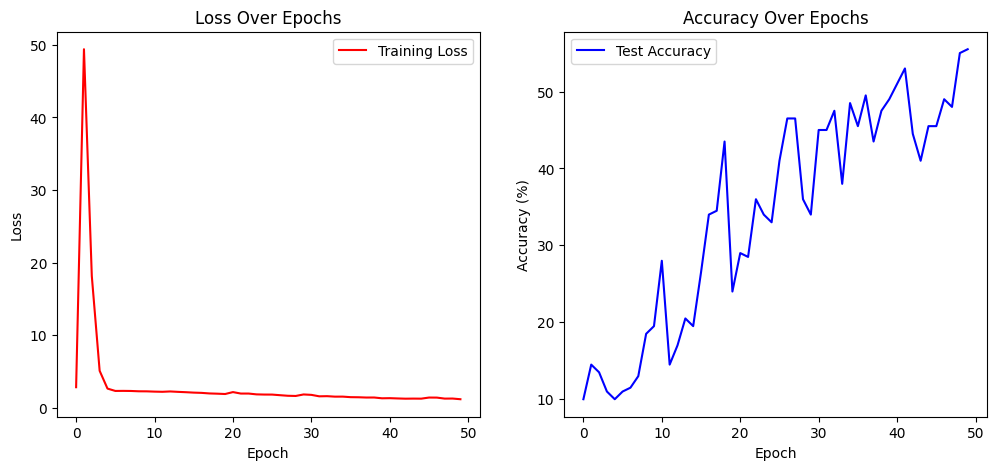

Success! Model saved as: music_genre_model.pth


In [ ]:
import matplotlib.pyplot as plt

# 1. Visualize the training progress
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss', color='red')
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(test_accuracies, label='Test Accuracy', color='blue')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.show()

# 2. Save the model file
model_name = 'music_genre_model.pth'
torch.save(model.state_dict(), model_name)
print(f"Success! Model saved as: {model_name}")